# Mixed problems

The `pymoo` interface supports the solution of mixed integer/float problems via the genetic algorithm `MixedVariableGA`. Here we demonstrate this by maximizing the number if points that fit inside a circle and lie on a regular grid.

These are the imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from iwopy import Problem, Objective
from iwopy.interfaces.pymoo import Optimizer_pymoo

The problem describes points on a regular grid of size `nx * ny`. Points that lie outside of the given radius will be marked by a `False` value in a boolean array called `valid`:

In [2]:
class GridProblem(Problem):

    def __init__(self, n_row_max, radius, min_dist, ctol=1e-3):
        super().__init__(name="grid_problem")

        self.n_row_max = n_row_max
        self.radius = float(radius)
        self.min_dist = float(min_dist)
        self.max_dist = 2*radius

        self.xy = None
        self.valid = None
    
    def initialize(self, verbosity=1):
        super().initialize(verbosity)
        self.apply_individual(self.initial_values_int(), self.initial_values_float())

    def var_names_int(self):
        return ["nx", "ny"]

    def initial_values_int(self):
        return [2, 2]

    def min_values_int(self):
        return [1, 1]

    def max_values_int(self):
        return [self.n_row_max, self.n_row_max]

    def var_names_float(self):
        return ["x0", "y0", "dx", "dy", "alpha"]

    def initial_values_float(self):
        return [0., 0., self.min_dist, self.min_dist, 0.]

    def min_values_float(self):
        return [-2*self.radius, -2*self.radius, self.min_dist, self.min_dist, 0.]

    def max_values_float(self):
        return [self.radius, self.radius, self.max_dist, self.max_dist, 90.]

    def apply_individual(self, vars_int, vars_float):
        """ Create points on a regular grid, and evaluate their validity """

        nx, ny = vars_int
        x0, y0, dx, dy, alpha = vars_float

        a = np.deg2rad(alpha)
        nax = np.array([np.cos(a), np.sin(a), 0.])
        naz = np.array([0., 0., 1.])
        nay = np.cross(naz, nax)

        self.xy = np.zeros((nx, ny, 2))
        self.xy[:] = np.array([x0, y0])[None, None, :]
        self.xy[:] += np.arange(nx)[:, None, None] * dx * nax[None, None, :2]
        self.xy[:] += np.arange(ny)[None, :, None] * dy * nay[None, None, :2]

        self.valid = np.linalg.norm(self.xy, axis=-1) <= self.radius

        return self.xy, self.valid

    def apply_population(self, vars_int, vars_float):
        """ Create points on a regular grid, and evaluate their validity """

        n_pop = vars_int.shape[0]
        nx = vars_int[:, 0]
        ny = vars_int[:, 1]
        x0 = vars_float[:, 0]
        y0 = vars_float[:, 1]
        dx = vars_float[:, 2]
        dy = vars_float[:, 3]
        alpha = vars_float[:, 4]

        a = np.deg2rad(alpha)
        nax = np.stack([np.cos(a), np.sin(a), np.zeros(a.shape)], axis=-1)
        naz = np.zeros_like(nax)
        naz[:, 2] = 1
        nay = np.cross(naz, nax)

        mx = np.max(nx)
        my = np.max(ny)
        self.xy = np.full((n_pop, mx, my, 2), -2*self.radius)
        for i in range(n_pop):
            self.xy[i, :nx[i], :ny[i]] = np.array([x0[i], y0[i]])[None, None, :]
            self.xy[i, :nx[i], :ny[i]] += np.arange(nx[i])[:, None, None] * dx[i, None, None, None] * nax[i, None, None, :2]
            self.xy[i, :nx[i], :ny[i]] += np.arange(ny[i])[None, :, None] * dy[i, None, None, None] * nay[i, None, None, :2]

        self.valid = np.linalg.norm(self.xy, axis=-1) <= self.radius

        return self.xy, self.valid

    def get_fig(self, xy=None, valid=None):

        if xy is None:
            xy = self.xy
        if valid is None:
            valid = self.valid

        nx, ny = xy.shape[:2]
        xy = xy.reshape(nx*ny, 2)[valid.reshape(nx*ny)]

        fig, ax = plt.subplots()
        ax.scatter(xy[:, 0], xy[:, 1], color="orange")
        ax.add_patch(plt.Circle((0, 0), self.radius, color="darkred", fill=False))
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"N = {len(xy)}, min_dist = {self.min_dist}")

        return fig

Notice that the `calculate_individual` and `calculate_population` functions return the current grid points and the validity array. This problem has two integer variables `nx` and `ny`, determining the number of grid points in x and y directions, respectively, and 5 float type variables.

Our objective is the maximization of the total number of points within the circle:

In [3]:
class MaxN(Objective):
    def __init__(self, problem):
        super().__init__(problem, "maxN", vnames_int=problem.var_names_int(), 
            vnames_float=problem.var_names_float())

    def n_components(self):
        return 1

    def maximize(self):
        return [True]

    def calc_individual(self, vars_int, vars_float, problem_results, cmpnts=None):
        xy, valid = problem_results
        return np.sum(valid)

    def calc_population(self, vars_int, vars_float, problem_results, cmpnts=None):
        xy, valid = problem_results
        return np.sum(valid, axis=(1, 2))[:, None]

This objective makes use of the returned validity array. We can now solve this with the appropriate algorithm from `pymoo`:

In [4]:
problem = GridProblem(n_row_max=1000, radius=5, min_dist=0.5)
problem.add_objective(MaxN(problem))
problem.initialize()

Problem 'grid_problem' (GridProblem): Initializing
--------------------------------------------------
  n_vars_int   : 2
  n_vars_float : 5
--------------------------------------------------
  n_objectives : 1
  n_obj_cmptns : 1
--------------------------------------------------
  n_constraints: 0
  n_con_cmptns : 0
--------------------------------------------------


In [5]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(
        vectorize=True,
    ),
    algo_pars=dict(
        type="MixedVariableGA",
        pop_size=40,
        seed=42,
    ),
    setup_pars=dict(
    ),
    term_pars=('n_eval', 1000),
)
solver.initialize()
solver.print_info()

Initializing Optimizer_pymoo
Selecting algorithm: MixedVariableGA (MixedVariableGA)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: MixedVariableGA
  pop_size: 40
  seed: 42

Termination:
------------
  n_eval: 1000



Here `tol` is an `IPOPT` parameter that defines the convergence tolerance. Now we are finally ready - let's solve the problem!

In [6]:
results = solver.solve()
solver.finalize(results)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       40 | -3.100000E+00 | -1.800000E+01


     2 |       80 | -5.425000E+00 | -2.400000E+01


     3 |      120 | -1.132500E+01 | -5.100000E+01


     4 |      160 | -2.195000E+01 | -6.800000E+01


     5 |      200 | -3.755000E+01 | -1.120000E+02


     6 |      240 | -6.500000E+01 | -1.530000E+02


     7 |      280 | -9.782500E+01 | -1.710000E+02


     8 |      320 | -1.257500E+02 | -2.590000E+02


     9 |      360 | -1.531750E+02 | -2.590000E+02


    10 |      400 | -1.788000E+02 | -2.680000E+02


    11 |      440 | -2.088500E+02 | -2.740000E+02


    12 |      480 | -2.367500E+02 | -2.750000E+02


    13 |      520 | -2.557750E+02 | -2.750000E+02


    14 |      560 | -2.630750E+02 | -2.800000E+02


    15 |      600 | -2.696000E+02 | -3.120000E+02


    16 |      640 | -2.793250E+02 | -3.120000E+02


    17 |      680 | -2.868250E+02 | -3.120000E+02


    18 |      720 | -2.933250E+02 | -3.120000E+02


    19 |      760 | -2.991250E+02 | -3.120000E+02


    20 |      800 | -3.042500E+02 | -3.150000E+02


    21 |      840 | -3.078500E+02 | -3.150000E+02


    22 |      880 | -3.110000E+02 | -3.150000E+02


    23 |      920 | -3.125500E+02 | -3.150000E+02


    24 |      960 | -3.135250E+02 | -3.160000E+02


    25 |     1000 | -3.140250E+02 | -3.160000E+02




Optimizer_pymoo: Optimization run finished
  Success: True
  Best maxN = 316.0


These are the results:

Results problem 'grid_problem':
--------------------------------
  Integer variables:
    0: nx = 721
    1: ny = 337
--------------------------------
  Float variables:
    0: x0    = -9.852999e+00
    1: y0    = -8.461444e+00
    2: dx    = 5.024268e-01
    3: dy    = 5.000655e-01
    4: alpha = 6.319982e+00
--------------------------------
  Objectives:
    0: maxN = 3.160000e+02
--------------------------------
  Success: True
--------------------------------



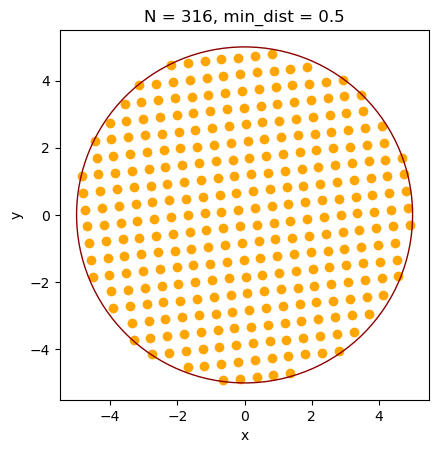

In [7]:
print(results)

fig = problem.get_fig()
plt.show()
plt.close(fig)

Clearly the circle is fully filled with points on a regular grid.